In [19]:
from PIL import Image
import numpy as np
import os
import open3d as o3d


In [20]:
def changeDep480to64(np_depth):
    lines = 16
    rows , cols = np_depth.shape
    pixel_y = [round(i * int(rows/lines)) for i in range(lines)]
    mask = np.ones((rows ,cols), dtype='bool')
    mask[pixel_y,:] = False
    np_depth[mask] = 0.0
    return np_depth

def simulateArc2(depth_data):
    """同一个原点按半径不同划分
    """
    lines = 16
    rows , cols = depth_data.shape
    pixel_y = np.array([round(i * int(rows/lines)) for i in range(lines)])
    origin = (rows, cols/2)
    distance = origin[0] - pixel_y
    mask = np.zeros((rows ,cols), dtype=np.bool)
    for i in range(rows):
        for j in range(cols):
            if round(np.sqrt((i-origin[0])**2 + (j-origin[1])**2)) in distance:
                mask[i][j] = True
                
    return mask


def simulateArc1(depth_data):
    lines = 16
    rows , cols = depth_data.shape
    coodi_y = np.array([round(i * int(rows/lines) + cols/2) for i in range(lines)])
    mask = np.zeros((rows ,cols), dtype=np.bool)
    for i in range(rows):
        for j in range(cols):
            for coodi_ in coodi_y:
                if round(np.sqrt((i-coodi_)**2 + (j-cols/2)**2)) == round(cols/2 * np.sqrt(2)):
                    mask[i][j] = True
    
    
    return mask

def simulateArc3(depth_data):
    lines = 16
    rows , cols = depth_data.shape
    height = cols - (np.sqrt(2)- 1 ) * cols / 2
    coodi_y = np.array([round(i * int(height / lines)) for i in range(lines)])
    mask = np.zeros((rows ,cols), dtype=np.bool)
    
    for i in range(rows):
        for j in range(cols):
            for coodi_ in coodi_y:
                if round(np.sqrt((i-coodi_)**2 + (j-cols/2)**2)) == round(cols/2 * np.sqrt(2)):
                    mask[i][j] = True
    
    return mask

def simulateArc4(depth_data):
    lines = 16
    rows , cols = depth_data.shape
    radius = cols / np.sin(np.radians(45))
    height = cols + cols / np.tan(np.radians(45))
    origin = (height, cols/2)
    
    radius2 = cols / np.sin(np.radians(45)) + 100
    mask = np.zeros((rows ,cols), dtype=np.bool)
    
    for i in range(rows):
        for j in range(cols):
            if round(np.sqrt((i-origin[0])**2 + (j-origin[1])**2)) == round(radius):
                mask[i][j] = True
            elif round(np.sqrt((i-origin[0])**2 + (j-origin[1])**2)) == round(radius2):
                mask[i][j] = True
            
    return mask




def Function(depth_data):
    # depth_data = changeDep480to64(depth_data)
    # mask = simulateArc4(depth_data)
    
    # depth_data = depth_data.astype(float)
    # depth_data[~mask] = np.nan
    
    
    return depth_data

#   =============================================================

def cloud_16(point_cloud):
    cloud_16 = []
    
    nums = 3
    # 定义LiDAR扫描参数
    num_scan_points = 90  # 90度扫描，可以根据需要调整
    lines = 64  # 90度扫描，可以根据需要调整
    # 初始化LiDAR点云数据
    degrees = num_scan_points / lines
    v_angle = [round(np.radians(i),nums) for i in np.arange(-45,18,degrees)]
    # 16等分
    for point in point_cloud:
        x, y, z = point
        
        distance = np.sqrt(x**2 + y**2 + z**2)
            
        alpha = round(np.arctan2(y,distance), nums)
        if alpha in v_angle :
            cloud_16.append(point)
        
    return np.array(cloud_16)

def voxel_down_sample(point_cloud):
    sparse_cloud = o3d.geometry.PointCloud()
    sparse_cloud.points = o3d.utility.Vector3dVector(point_cloud)
    voxel_size = 0.1
    voxel_cloud = sparse_cloud.voxel_down_sample(voxel_size)
    output_cloud = np.asarray(voxel_cloud.points)
    return output_cloud

def PointFunction(point_cloud):
    
    point_cloud = cloud_16(point_cloud)
    point_cloud = voxel_down_sample(point_cloud)
    return point_cloud

In [21]:
DEPTH_SCALE_M = 0.001

# 以下示例假设相机参数为 fx, fy（焦距），cx, cy（光学中心）
fx = 392.323 
fy = 392.323
cx = 319.158 
cy = 240.853
nums = 3


# 定义LiDAR扫描参数
num_scan_points = 90  # 90度扫描，可以根据需要调整
lines = 32  # 90度扫描，可以根据需要调整
min_angle = -np.pi / 4  # 最小扫描角度
max_angle = np.pi / 4  # 最大扫描角度
# 初始化LiDAR点云数据
lidar_points = []
digess = num_scan_points / lines
v_angle = [round(np.radians(i),nums) for i in np.arange(-45,45,digess)]
## D435
# fx = 392.323 
# fy = 392.323
# cx = 322.776 
# cy = 239.792

depth_image = Image.open('image_93.png')
depth_data = np.array(depth_image)
depth_data = Function(depth_data)
# 创建一个空的点云列表，用于存储点的坐标
point_cloud = []

# 遍历深度图像的每个像素
for y in range(depth_data.shape[0]):
    for x in range(depth_data.shape[1]):
        # 获取深度值
        depth = depth_data[y, x] * DEPTH_SCALE_M

        # 计算对应的点的坐标（假设 Z 轴为深度，X 和 Y 轴为图像平面）
        if depth > 0:
            point_x = (x - cx) * depth / fx
            point_y = (y - cy) * depth / fy
            point_z = depth

            # distance = np.sqrt(point_x**2 + point_y**2 + point_z**2)
            
            # beta = round(np.arctan2(point_y,distance), nums)
            # if not (beta in v_angle) :
            #     continue
            
            # 将点的坐标添加到点云列表中
            point_cloud.append([point_x, point_y, point_z])

point_cloud = np.array(point_cloud)

point_cloud = PointFunction(point_cloud)

# 绕 Y 轴顺时针旋转 90 度
angle_y = np.radians(90)  # 将角度转换为弧度
rotation_y = np.array([[np.cos(angle_y), 0, np.sin(angle_y)],
                    [0, 1, 0],
                    [-np.sin(angle_y), 0, np.cos(angle_y)]])
rotated_points = np.dot(point_cloud, rotation_y.T)
# 绕 X 轴逆时针旋转 90 度
angle_x = np.radians(-90)  # 将角度转换为弧度
rotation_x = np.array([[1, 0, 0],
                    [0, np.cos(angle_x), -np.sin(angle_x)],
                    [0, np.sin(angle_x), np.cos(angle_x)]])
rotated_points = np.dot(rotated_points, rotation_x.T)

nan_mask = np.isnan(rotated_points).any(axis=1)
point_cloud = rotated_points[~nan_mask]
# 步骤 4：可选地，保存点云数据到文件或进行可视化
# 这里不提供具体的点云保存或可视化代码，因为涉及到不同的库和工具。


In [22]:

# 将点云列表转换为 NumPy 数组


root, extension = os.path.splitext('image_93.png')
np.save('point_'+root[6:]+'.npy', point_cloud)

print(point_cloud.shape)
    

(649, 3)


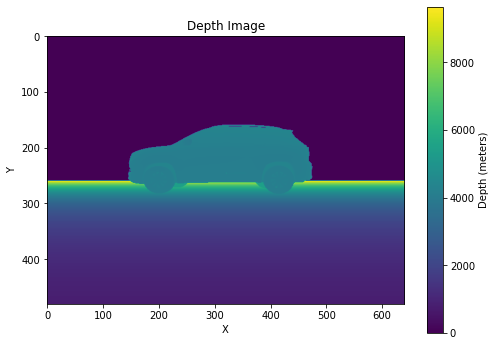

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(depth_data, cmap='viridis')  # 使用 'viridis' 色彩映射（可以根据需要选择其他色彩映射）
plt.colorbar(label='Depth (meters)')  # 添加颜色条，标明深度的单位
plt.title('Depth Image')  # 设置图像标题
plt.xlabel('X')  # 设置X轴标签
plt.ylabel('Y')  # 设置Y轴标签
plt.show()

In [24]:

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
pcd.paint_uniform_color([1.0, 0.5, 0.0])  # 设置橙色

# pcd2 = o3d.geometry.PointCloud()
# pcd2.points = o3d.utility.Vector3dVector(unproce_point_cloud)
# pcd2.paint_uniform_color([1.0, 0.0, 0.0])  # 设置红色

lidar_point_cloud  = np.load('lidarpoint_93.npy')
lidar_point_cloud[:,2] += 0.22
pcd3 = o3d.geometry.PointCloud()
pcd3.points = o3d.utility.Vector3dVector(lidar_point_cloud)
pcd3.paint_uniform_color([0.0, 0.5, 0.3])  # 设置红色


coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

# 创建一个场景并将点云、包围框和坐标系添加到场景中
scene = o3d.visualization.Visualizer()
scene.create_window()
scene.add_geometry(pcd)        # 添加点云
# scene.add_geometry(pcd2)        # 添加点云
scene.add_geometry(pcd3)        # 添加点云
scene.add_geometry(coord_frame)  # 添加坐标系


# 设置视角
view_control = scene.get_view_control()
view_control.set_lookat([0, 0, 0])  # 设置视点
view_control.set_up([1, 0, 0])     # 设置视角上方的方向

# 显示场景
scene.run()
scene.destroy_window()